In [1]:
from typing import Optional
from omegaconf import DictConfig

import logging
import torch
import matplotlib.pyplot as plt

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.utils.config_run import ConfigRun
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:2"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 0,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

foundation_forest_weights = 'outputs_done/foundation_forest_big_300k/weights/model_step_300000.pt'
foundation_pfn_weights = 'outputs_done/foundation_tabpfn_big/weights/model_step_500000.pt'
foundation_forest_128_weights = 'outputs_done/foundation_forest_dim_128/weights/model_step_300000.pt'
foundation_forest_256_weights = 'outputs_done/foundation_forest_dim_256/weights/model_step_300000.pt'

In [2]:
import numpy as np

dataset = OpenMLDataset(cfg.openml_dataset_id, cfg.task, cfg.dataset_size)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)
features = [0, 3]

x_train = x_train[:, features]
x_val = x_val[:, features]
x_test = x_test[:, features]

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [4]:
def irregularity_value(pred_grid):

    pred = pred_grid[:, :, 0]

    pred_middle = pred[1:-1, 1:-1]
    pred_up = pred[:-2, 1:-1]
    pred_down = pred[2:, 1:-1]
    pred_left = pred[1:-1, :-2]
    pred_right = pred[1:-1, 2:]

    pred_diff = np.abs(pred_middle - pred_up) + np.abs(pred_middle - pred_down) + np.abs(pred_middle - pred_left) + np.abs(pred_middle - pred_right)

    return pred_diff.sum() / pred_diff.size

In [5]:
import einx

x1 = (np.arange(1000) / 100 - 0.5) * 6
x2 = (np.arange(1000) / 100 - 0.5) * 6

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

In [6]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
score_test_mlp = mlp.score(x_test, y_test)

score_test_mlp

0.7888320288982541

Text(0.5, 1.0, 'MLP (acc: 0.789, irreg: 0.0024)')

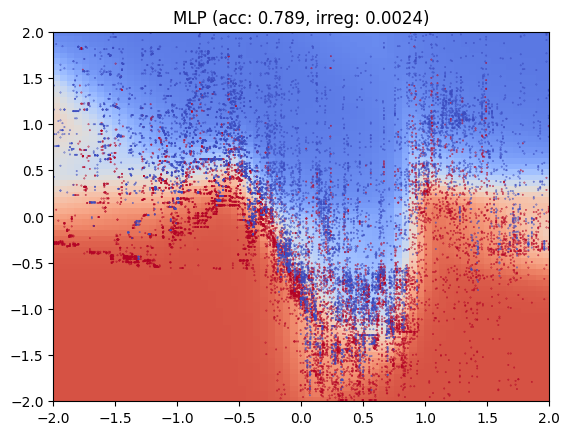

In [7]:
preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"MLP (acc: {score_test_mlp:.3f}, irreg: {irreg_value:.4f})")

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
score_test_rf = clf.score(x_test, y_test)

score_test_rf


0.8693558097531607

In [9]:
clf.feature_importances_

array([0.41942146, 0.58057854])

Text(0.5, 1.0, 'Random Forest (acc: 0.869, irreg: 0.0126)')

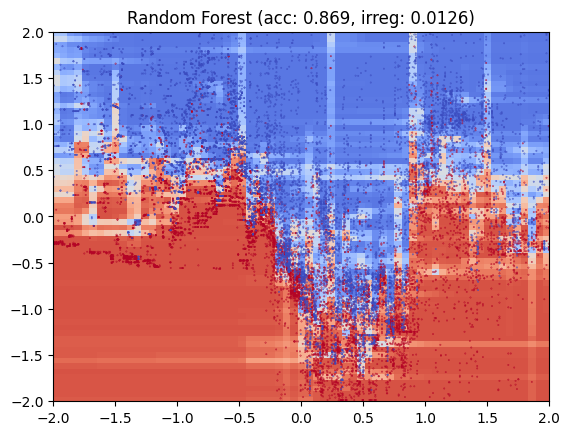

In [10]:
preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Random Forest (acc: {score_test_rf:.3f}, irreg: {irreg_value:.4f})")

In [11]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights

model_pfn = get_model(cfg, x_train, y_train, categorical_indicator)
trainer_pfn = get_trainer(cfg, model_pfn)
trainer_pfn.train(x_train, y_train)

loss_train, score_train = trainer_pfn.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer_pfn.test(x_train, y_train, x_val, y_val)
loss_test, score_test_tabpfn = trainer_pfn.test(x_train, y_train, x_test, y_test)

score_test_tabpfn

0.7853201031684875

In [12]:
preds_pfn_raw = trainer_pfn.predict(x_train, y_train, x_grid)
preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

irreg_value = irregularity_value(preds_pfn)


Text(0.5, 1.0, 'Foundation PFN ZeroShot (acc: 0.785, irreg: 0.0022)')

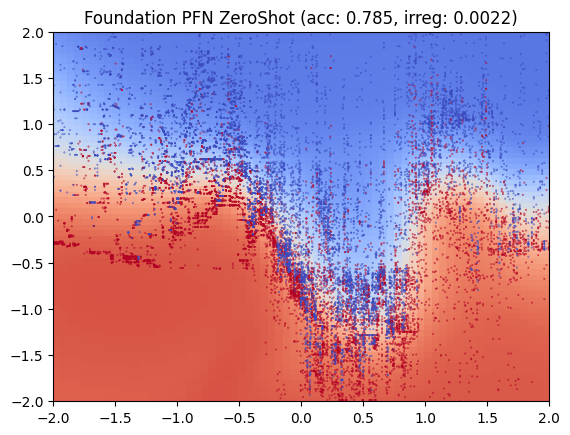

In [13]:
plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Foundation PFN ZeroShot (acc: {score_test_tabpfn:.3f}, irreg: {irreg_value:.4f})")

In [14]:
cfg.hyperparams['path_to_weights'] = foundation_forest_weights

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

score_test_forest

0.7679610848426819

In [15]:
preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

Text(0.5, 1.0, 'Foundation Forest ZeroShot (acc: 0.768, irreg: 0.0023)')

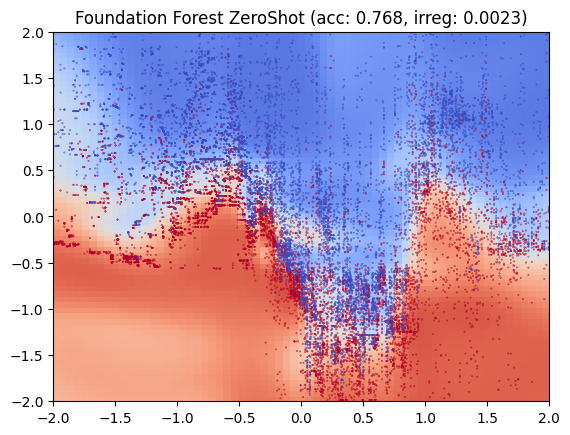

In [16]:
plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest ZeroShot (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 16:57:31.183 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4404 | Train score: 0.7962 | Val loss: 0.4419 | Val score: 0.7930
2024-02-13 16:57:32.540 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4470 | Train score: 0.7869 | Val loss: 0.4446 | Val score: 0.7910
2024-02-13 16:57:33.404 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4359 | Train score: 0.7875 | Val loss: 0.4594 | Val score: 0.7725
2024-02-13 16:57:34.262 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4392 | Train score: 0.7919 | Val loss: 0.4417 | Val score: 0.7925
2024-02-13 16:57:35.596 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4385 | Train score: 0.7837 | Val loss: 0.4399 | Val score: 0.7980
2024-02-13 16:57:36.954 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4413 | Train sco

Text(0.5, 1.0, 'Foundation PFN (acc: 0.804, irreg: 0.0039)')

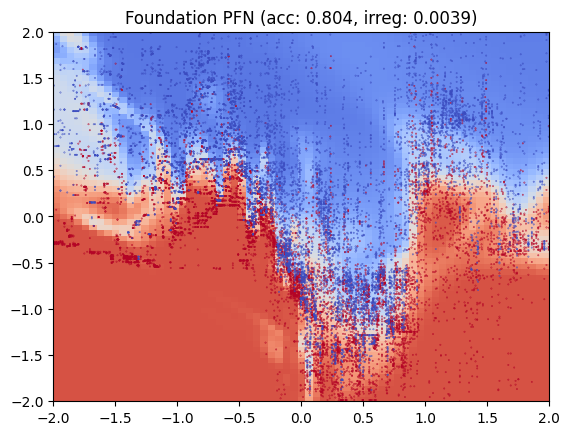

In [17]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights
cfg.hyperparams['max_epochs'] = 300

model_pfn = get_model(cfg, x_train, y_train, categorical_indicator)
trainer_pfn = get_trainer(cfg, model_pfn)
trainer_pfn.train(x_train, y_train)

loss_train, score_train = trainer_pfn.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer_pfn.test(x_train, y_train, x_val, y_val)
loss_test, score_test_tabpfn = trainer_pfn.test(x_train, y_train, x_test, y_test)

preds_pfn_raw = trainer_pfn.predict(x_train, y_train, x_grid)
preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

irreg_value = irregularity_value(preds_pfn)

plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Foundation PFN (acc: {score_test_tabpfn:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 17:03:34.525 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4564 | Train score: 0.7794 | Val loss: 0.4916 | Val score: 0.7460
2024-02-13 17:03:35.861 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4827 | Train score: 0.7512 | Val loss: 0.4412 | Val score: 0.7885
2024-02-13 17:03:37.196 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4356 | Train score: 0.8025 | Val loss: 0.4396 | Val score: 0.7930
2024-02-13 17:03:38.534 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4496 | Train score: 0.7875 | Val loss: 0.4432 | Val score: 0.7845
2024-02-13 17:03:39.393 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4513 | Train score: 0.7775 | Val loss: 0.4432 | Val score: 0.7940
2024-02-13 17:03:40.253 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4390 | Train sco

Text(0.5, 1.0, 'Foundation Forest (acc: 0.802, irreg: 0.0027)')

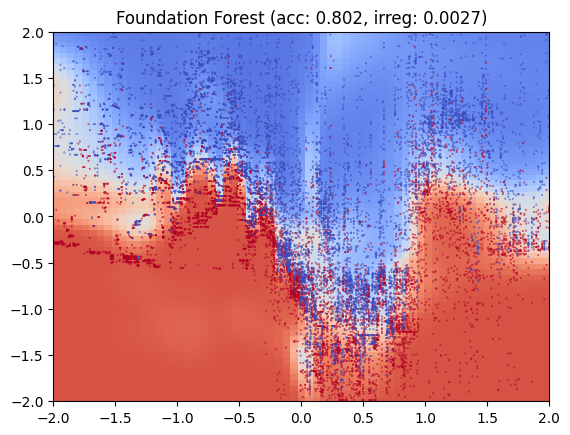

In [18]:
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 300

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 17:06:34.809 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4381 | Train score: 0.7781 | Val loss: 0.4624 | Val score: 0.7665
2024-02-13 17:06:35.618 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4394 | Train score: 0.7875 | Val loss: 0.4509 | Val score: 0.7815
2024-02-13 17:06:36.429 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4334 | Train score: 0.7969 | Val loss: 0.4502 | Val score: 0.7820
2024-02-13 17:06:37.239 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4500 | Train score: 0.7819 | Val loss: 0.4484 | Val score: 0.7830
2024-02-13 17:06:38.049 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4188 | Train score: 0.8137 | Val loss: 0.4476 | Val score: 0.7840
2024-02-13 17:06:38.859 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4308 | Train sco

Text(0.5, 1.0, 'Foundation Forest 256 (acc: 0.801, irreg: 0.0043)')

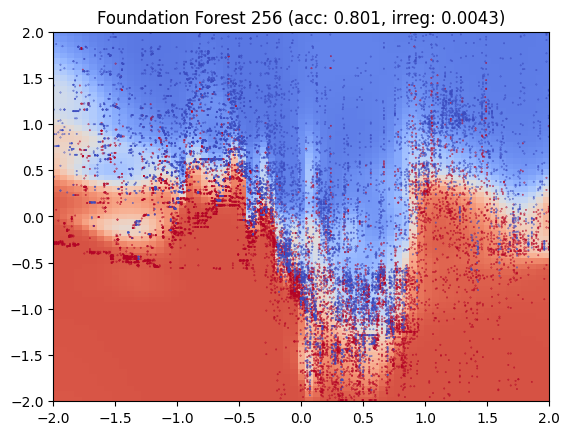

In [19]:
cfg.hyperparams['path_to_weights'] = foundation_forest_256_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 256

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest 256 (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")

2024-02-13 17:09:08.872 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 000 | Train loss: 0.4658 | Train score: 0.7662 | Val loss: 0.4355 | Val score: 0.7955
2024-02-13 17:09:09.530 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 001 | Train loss: 0.4328 | Train score: 0.7775 | Val loss: 0.4347 | Val score: 0.7990
2024-02-13 17:09:10.188 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 002 | Train loss: 0.4148 | Train score: 0.8087 | Val loss: 0.4360 | Val score: 0.7990
2024-02-13 17:09:10.801 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 003 | Train loss: 0.4365 | Train score: 0.7881 | Val loss: 0.4338 | Val score: 0.8005
2024-02-13 17:09:11.459 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 004 | Train loss: 0.4353 | Train score: 0.7850 | Val loss: 0.4339 | Val score: 0.7975
2024-02-13 17:09:12.073 | INFO     | tabularbench.core.trainer_finetune:train:86 - Epoch 005 | Train loss: 0.4551 | Train sco

Text(0.5, 1.0, 'Foundation Forest 128 (acc: 0.797, irreg: 0.0027)')

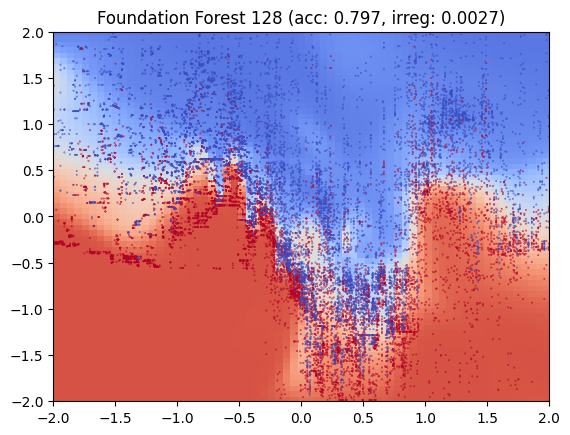

In [20]:
cfg.hyperparams['path_to_weights'] = foundation_forest_128_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 128

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test_forest = trainer.test(x_train, y_train, x_test, y_test)

preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

irreg_value = irregularity_value(preds_forest)

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"Foundation Forest 128 (acc: {score_test_forest:.3f}, irreg: {irreg_value:.4f})")